In [ ]:
!pip install pyspark


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Better view for charts
# High quality image
%config InlineBackend.figure_format = 'svg'
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 0. Create Spark Session
import os
import sys
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import regexp_extract, col, when, avg, lag, abs as spark_abs
from pyspark.sql.functions import col, log1p, abs as spark_abs

from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Updated train and test split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split


spark = SparkSession.builder \
    .appName("UNSW_Preprocessing") \
    .getOrCreate()

26/02/21 17:13:54 WARN Utils: Your hostname, ijuwon-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 10.41.87.186 instead (on interface en0)
26/02/21 17:13:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/21 17:13:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/21 17:13:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
def load_and_prep_spark_data():
    # Update paths
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'

    # # Juwon's Local file path
    # test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    # train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    
    print("Loading data...")
    df_train_orig = spark.read.csv(train_path, header=True, inferSchema=True)
    df_test_orig = spark.read.csv(test_path, header=True, inferSchema=True)

    # 1. Combine Datasets (Fixes Split Mismatch)
    # Drop ID and attack_cat (Fixes Leakage)
    df_full = df_train_orig.unionByName(df_test_orig).drop('id', 'attack_cat')

    # 2. Feature Engineering (Matches RF Features)
    # Add pkt_ratio and ttl_gap so SVM has the same info as RF
    df_full = df_full.withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1))
    df_full = df_full.withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

    print(f"Total Records: {df_full.count()}")

    # 3. Stratified Split (70% Train, 15% Val, 15% Test)
    # We split by label to ensure balance
    zeros = df_full.filter(col("label") == 0)
    ones = df_full.filter(col("label") == 1)

    train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
    train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)

    train_data = train_0.union(train_1)
    val_data = val_0.union(val_1)
    test_data = test_0.union(test_1)

    print(f"Split Sizes -> Train: {train_data.count()}, Val: {val_data.count()}, Test: {test_data.count()}")
    return train_data, val_data, test_data

train_df, val_df, test_df = load_and_prep_spark_data()

Loading data...


Total Records: 257673


26/02/21 17:13:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Split Sizes -> Train: 180973, Val: 38573, Test: 38127


## Add new columns

In [4]:
from pyspark.sql.functions import isnan, when, count

def missing_value_report(df):
    return df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)
        for c in df.columns
    ])

print("train_df missing value report")
missing_value_report(train_df).show(truncate=False)
print("test_df missing value report")
missing_value_report(test_df).show(truncate=False)
print("val_df missing value report")
missing_value_report(val_df).show(truncate=False)


train_df missing value report


+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+-----+---------+-------+
|dur|proto|service|state|spkts|dpkts|sbytes|dbytes|rate|sttl|dttl|sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|label|pkt_ratio|ttl_gap|
+---+-----+-------+-----+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+---

## Feature Engineering

In [5]:
# Add new columns pkt_ratio and ttl_gap
spark_train_df = train_df \
    .withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1)) \
    .withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

spark_test_df = test_df \
    .withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1)) \
    .withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))
    
spark_val_df = val_df \
    .withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1)) \
    .withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))


In [6]:

# Exclude_columns
# trans_depth(only zeros)
# response_body_len(only zeros)
excluded = {"attack_cat", "id"}

selected_cols = [c for c in train_df.columns if c not in excluded]


# select dataframe with only selected columns
df_filtered = train_df.select(*selected_cols)

# Extract Numeric Columns
from pyspark.sql.types import NumericType


numeric_cols = [
    f.name for f in df_filtered.schema.fields
    if isinstance(f.dataType, NumericType) and f.name != "label"
]

print("Numeric columns:", numeric_cols)


# only filter the any nulls detected columns
null_summary = df_filtered.select([
    count(
        when(col(c).isNull() | isnan(col(c)), c)
    ).alias(c)
    for c in numeric_cols
])

# Show all data
null_summary.show(truncate=False)



Numeric columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'pkt_ratio', 'ttl_gap']
+---+-----+-----+------+------+----+----+----+-----+-----+-----+-----+------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+---------+-------+
|dur|spkts|dpkts|sbytes|dbytes|rate|sttl|dttl|sload|dload|sloss|dloss|sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|sm

## Visualization

### Distributions

FileNotFoundError: [Errno 2] No such file or directory: 'EDA_images/task2_distribution.png'

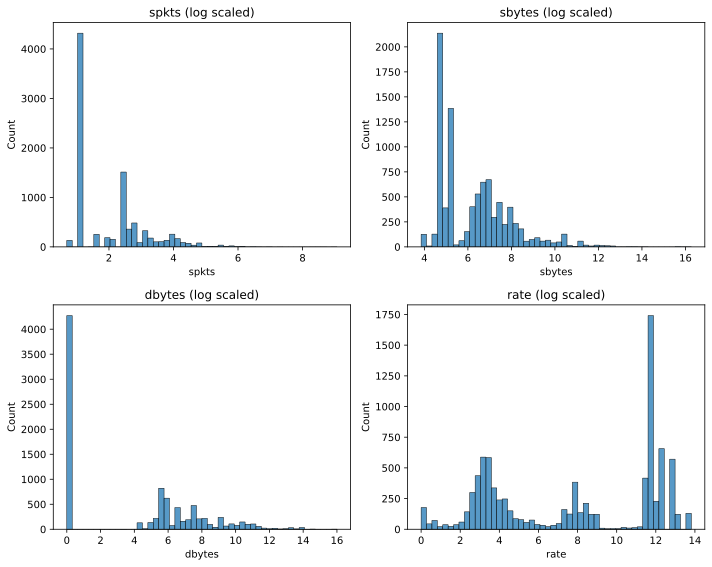

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sample_pd = spark_train_df.select(
    "spkts", "sbytes", "dbytes", "rate"
).sample(fraction=0.05, seed=42).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(10,8))

sns.histplot(np.log1p(sample_pd["spkts"]), bins=50, ax=axes[0,0])
axes[0,0].set_title("spkts (log scaled)")

sns.histplot(np.log1p(sample_pd["sbytes"]), bins=50, ax=axes[0,1])
axes[0,1].set_title("sbytes (log scaled)")

sns.histplot(np.log1p(sample_pd["dbytes"]), bins=50, ax=axes[1,0])
axes[1,0].set_title("dbytes (log scaled)")

sns.histplot(np.log1p(sample_pd["rate"]), bins=50, ax=axes[1,1])
axes[1,1].set_title("rate (log scaled)")

plt.tight_layout()
plt.savefig("EDA_images/task2_distribution.png", dpi=300)
plt.show()


### Correlation Visulization

/var/folders/vy/xvrzy34d5r3dcmcbf4jj5sz80000gn/T/ipykernel_71935/4257600796.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


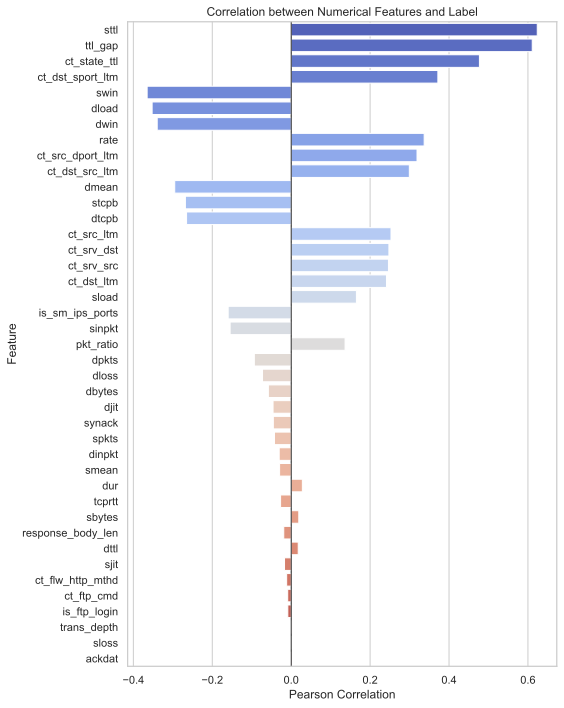

In [ ]:


# Correlation Check to identify unnecessary columns
# Calculate corelation of each labels
corr_rows = []

for c in numeric_cols:
    corr_val =spark_train_df.stat.corr(c, "label") # => 여기가 문제
    corr_rows.append((c, corr_val))

# convert to spark DF
corr_df = spark.createDataFrame(
    corr_rows,
    ["feature", "correlation"]
)

# convert to pandas DF
corr_pd = (
    corr_df
    .toPandas()
    .sort_values(by="correlation", key=abs, ascending=False)
)


sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 10))
sns.barplot(
    data=corr_pd,
    x="correlation",
    y="feature",
    palette="coolwarm"
)

plt.axvline(0, color="black", linewidth=0.8)
plt.title("Correlation between Numerical Features and Label")
plt.xlabel("Pearson Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("EDA_images/task2_correlation.png", dpi=300)
plt.show()

### Outlier Visualization

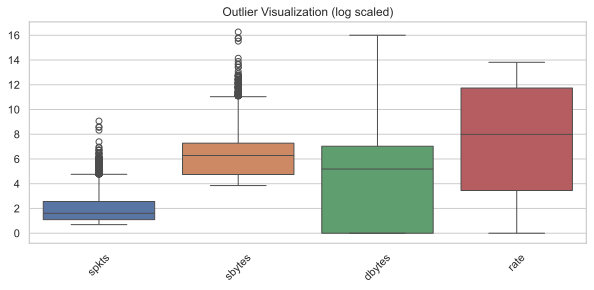

In [ ]:
box_cols = ["spkts", "sbytes", "dbytes", "rate"]

box_pd = spark_train_df.select(box_cols) \
    .sample(0.05, seed=42) \
    .toPandas()

plt.figure(figsize=(10,4))
sns.boxplot(data=np.log1p(box_pd))
plt.xticks(rotation=45)
plt.title("Outlier Visualization (log scaled)")
plt.savefig("EDA_images/task2_outliers_log_scaled.png", dpi=300)
plt.show()


### Label Distribution

+-----+------+
|label| count|
+-----+------+
|    0| 65421|
|    1|115552|
+-----+------+



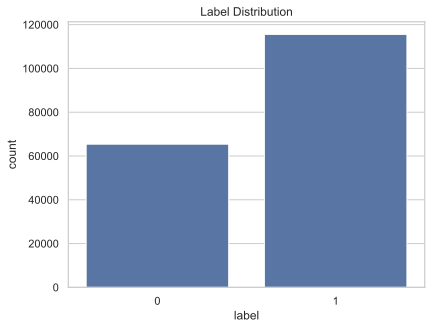

In [ ]:
label_count_df = spark_train_df.groupBy("label").count()
label_count_df.show()

label_pd = label_count_df.toPandas()

sns.barplot(x="label", y="count", data=label_pd)
plt.title("Label Distribution")
plt.savefig("EDA_images/task2_label_distribution.png", dpi=300)
plt.show()


### Correlation heatmap

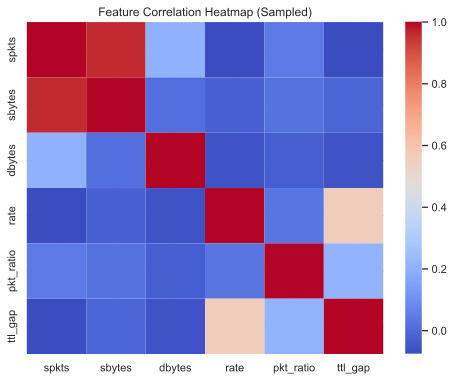

In [ ]:
corr_cols = ["spkts", "sbytes", "dbytes", "rate", "pkt_ratio", "ttl_gap"]

corr_pd = spark_train_df.select(corr_cols) \
    .sample(0.05, seed=42) \
    .toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(corr_pd.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap (Sampled)")
plt.savefig("EDA_images/task2_feature_correlation_heatmap.png", dpi=300)
plt.show()


**Opinion** 

After removing id (which is primray key) and attack_cat which includes the answers of the data to check any unnecessary data or data trend.

**Opinion** 

StandardScaler was considered prior to PCA, however the intrusion detection requires to identify any kind of outliers available therefore, standardizing the data is not an appropriate way to preprocess. However, since some featurs have same direction of correlation values, we applied PCA method to reduce feature dimensions.

## TRY 1: Preprocessing with Numerical data only
> ### RFormula → features → PCA → pca_features → Model


In [ ]:
from pyspark.sql.functions import col

preparedDF = train_df \
    .drop("id", "attack_cat") \
    .withColumn("label", col("label").cast("integer")) \
    .cache()

  preparedDF
    ↓ (stratified split)
  train_data / val_data / test_data
    ↓ (StringIndexer fit on train, transform all)
  train_data / val_data / test_data
    ↓ (VectorAssembler)
  trainDF / valDF / testDF
    ↓
  model.fit(trainDF)

In [ ]:
from pyspark.ml.feature import PCA, StringIndexer, VectorAssembler
from pyspark.sql.types import StringType
from pyspark.ml.classification import LogisticRegression

## Step 0: Categorical_str_cols
categorical_str_cols = [
    f.name for f in preparedDF.schema.fields
    if isinstance(f.dataType, StringType)
]
df_labeled = preparedDF.withColumn("label", col("label").cast("integer"))

## Step 1: Stratified split
zeros = df_labeled.filter(col("label") == 0)
ones  = df_labeled.filter(col("label") == 1)

train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)


# These data can be used in next step
train_data = train_0.union(train_1).cache()
val_data   = val_0.union(val_1).cache()
test_data  = test_0.union(test_1).cache()


## Step1: StringIndexer (preparedDF)
for col_name in categorical_str_cols:
    idx_col = f"{col_name}_idx"
    if idx_col in train_data.columns:
        continue  # 이미 있으면 스킵
    indexer = StringIndexer(
        inputCol=col_name,
        outputCol=idx_col,
        handleInvalid="keep"
    )
    train_data = indexer.fit(train_data).transform(train_data)
    val_data = indexer.fit(val_data).transform(val_data)
    test_data = indexer.fit(test_data).transform(test_data)

## Step 2: VectorAssembler
feature_cols = [
    c for c in train_data.columns
    if c not in ["id", "label", "attack_cat", "proto", "service", "state"]
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

trainDF = assembler.transform(train_data) \
    .select("features", col("label").cast("int"))

valDF = assembler.transform(val_data) \
    .select("features", col("label").cast("int"))

testDF = assembler.transform(test_data) \
    .select("features", col("label").cast("int"))
    


## Step 4: PCA (train_only)
pca = PCA(k=30, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(trainDF)

pca_train = pca_model.transform(trainDF).cache()
pca_test = pca_model.transform(testDF).cache()
pca_val = pca_model.transform(valDF).cache()


## Step 5: Logistic Regression
lr = LogisticRegression(
    featuresCol="pca_features",
    labelCol="label",
    maxIter=20,
    regParam=0.01
)

model = lr.fit(pca_train)

## Step 6: Prediction
predictions = model.transform(pca_test)

predictions.select(
    "label", "probability", "prediction"
).show(10, truncate=False)


26/02/21 17:03:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/21 17:03:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-----+-----------------------------------------+----------+
|label|probability                              |prediction|
+-----+-----------------------------------------+----------+
|0    |[0.9649156335553083,0.035084366444691706]|0.0       |
|0    |[0.9649156278464763,0.03508437215352367] |0.0       |
|0    |[0.22565256481184187,0.7743474351881581] |1.0       |
|0    |[0.8815472311787849,0.11845276882121514] |0.0       |
|0    |[0.8776589340002642,0.12234106599973582] |0.0       |
|0    |[0.2277406961121375,0.7722593038878625]  |1.0       |
|0    |[0.6740893532453932,0.3259106467546068]  |0.0       |
|0    |[0.8823874272546389,0.11761257274536108] |0.0       |
|0    |[0.8960968933396974,0.10390310666030256] |0.0       |
|0    |[0.9042319861138394,0.09576801388616063] |0.0       |
+-----+-----------------------------------------+----------+
only showing top 10 rows



### Test PCA prediction

In [ ]:
# Evaluate Multiple Matrix for Testing (For me, Model is not necessary, but in order to test my preprocessed data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

metrics = { "accuracy": "accuracy",
           "precision": "weightedPrecision",
           "recall": "weightedRecall",
           "f1": "f1"
           }

print("="*40)
print("PCA TRAIN RESULTS")
print("="*40)
for name, metric in metrics.items():
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName=metric
    )
    print(f"\n{name}: {evaluator.evaluate(predictions):.4f}")

PCA TRAIN RESULTS

accuracy: 0.8935

precision: 0.9034

recall: 0.8935

f1: 0.8891


## TRY 2 : Preprocessing with Categorical data + numerical data for tree
> ### RFormula → features → Model

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

## Step 1: Stratified split
df_labeled = preparedDF.withColumn("label", col("label").cast("integer"))

zeros = df_labeled.filter(col("label") == 0)
ones  = df_labeled.filter(col("label") == 1)

train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)


# These data can be used in next step
train_data = train_0.union(train_1).cache()
val_data   = val_0.union(val_1).cache()
test_data  = test_0.union(test_1).cache()

# Find string columns
categorical_str_cols = [
    f.name for f in train_data.schema.fields
    if isinstance(f.dataType, StringType)
]

## Step1: StringIndexer (preparedDF)
for col_name in categorical_str_cols:
    idx_col = f"{col_name}_idx"
    if idx_col in train_data.columns:
        continue  # 이미 있으면 스킵
    indexer = StringIndexer(
        inputCol=col_name,
        outputCol=idx_col,
        handleInvalid="keep"
    )
    train_data = indexer.fit(train_data).transform(train_data)
    val_data = indexer.fit(val_data).transform(val_data)
    test_data = indexer.fit(test_data).transform(test_data)

## Step 2: VectorAssembler
feature_cols = [
    c for c in train_data.columns
    if c not in ["id", "label", "attack_cat", "proto", "service", "state"]
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"
)

trainDF = assembler.transform(train_data) \
    .select("features", col("label").cast("int"))

valDF = assembler.transform(val_data) \
    .select("features", col("label").cast("int"))

testDF = assembler.transform(test_data) \
    .select("features", col("label").cast("int"))

# 5) LR train + predict
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.01)
model = lr.fit(trainDF)

pred = model.transform(testDF)
pred.select("label", "probability", "prediction").show(10, truncate=False)

26/02/21 17:03:38 WARN CacheManager: Asked to cache already cached data.
26/02/21 17:03:38 WARN CacheManager: Asked to cache already cached data.
26/02/21 17:03:38 WARN CacheManager: Asked to cache already cached data.


+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.9904557577543566,0.00954424224564343]|0.0       |
|0    |[0.9904557602884924,0.00954423971150764]|0.0       |
|0    |[0.2181936901552349,0.7818063098447651] |1.0       |
|0    |[0.8263723852983702,0.1736276147016298] |0.0       |
|0    |[0.7858537461869951,0.2141462538130049] |0.0       |
|0    |[0.212772365907583,0.787227634092417]   |1.0       |
|0    |[0.5011668471969427,0.4988331528030573] |0.0       |
|0    |[0.7949987054094295,0.20500129459057048]|0.0       |
|0    |[0.830459277968152,0.169540722031848]   |0.0       |
|0    |[0.8373646950097888,0.16263530499021117]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Test Model Output

In [ ]:
# Evaluate Multiple Matrix for Testing (For me, Model is not necessary, but in order to test my preprocessed data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

metrics = { "accuracy": "accuracy",
           "precision": "weightedPrecision",
           "recall": "weightedRecall",
           "f1": "f1"
           }

print("="*40)
print("Normal Cat+Num TRAIN RESULTS")
print("="*40)
for name, metric in metrics.items():
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName=metric
    )
    print(f"{name}: {evaluator.evaluate(predictions):.4f}")

Normal Cat+Num TRAIN RESULTS
accuracy: 0.8935
precision: 0.9034
recall: 0.8935
f1: 0.8891
